# LAB 6 MOS:  Algoritmos Genéticos para Resolución de Problemas Complejos

- Samuel Augusto Hernandez 202213772
- Tomas Alberto Rodriguez 2022128686

## Problema 1: Corridor Crawler (Laberinto Determinístico)

### Representación Cromosómica

El tamaño del cromosoma será de n², donde n es el tamaño del laberinto. Este tamaño asegura que nunca se necesitarán más de n² pasos para llegar a la salida, ya que el robot siempre encontrará la salida en un número menor de pasos, y las dimensiones del laberinto dictarán el límite máximo de movimientos

Cada gen representará un movimiento. Los posibles movimientos seran 4 direcciones: norte, sur, este, oeste. Cada gen será representado por un número que indica la acción a tomar.

Si en algun punto llega a la salida antes de su ultimo movimiento, se considera que es correcto y no se toma en cuenta lo que quede de cromosoma



### Implementación


Mejor cromosoma: [3, 3, 0, 0, 2, 1, 0, 1, 2, 2, 3, 2, 3, 3, 0, 0, 1, 3, 3, 1, 3, 2, 3, 3, 3, 0, 2, 3, 2, 2, 2, 1, 3, 0, 0, 0, 0, 3, 0, 2, 1, 0, 2, 0, 3, 2, 3, 0, 2, 2, 2, 0, 1, 1, 3, 1, 0, 2, 2, 0, 2, 1, 3, 0, 2, 0, 1, 2, 2, 2, 2, 0, 1, 1, 3, 0, 3, 2, 1, 1, 3, 1, 2, 3, 2, 1, 1, 3, 3, 2, 0, 1, 0, 1, 2, 2, 0, 3, 0, 0, 2, 0, 2, 0, 1, 2, 1, 3, 2, 3, 2, 1, 2, 0, 1, 3, 3, 1, 2, 1, 2, 3, 0, 2, 1, 3, 1, 0, 2, 0, 2, 1, 0, 3, 1, 1, 2, 3, 0, 0, 3, 3, 1, 3, 1, 1, 3, 2, 1, 1, 0, 2, 1, 3, 3, 0, 3, 2, 2, 1, 2, 1, 0, 0, 1, 2, 2, 1, 1, 0, 1, 2, 1, 1, 1, 0, 1, 3, 3, 3, 2, 2, 1, 3, 0, 3, 3, 2, 2, 0, 2, 0, 2, 3, 3, 0, 0, 2, 2, 0, 0, 3, 3, 0, 3, 1, 2, 3, 1, 0, 3, 0, 2, 0, 1, 0, 1, 3, 3, 1, 2, 2, 2, 3, 3, 2, 0, 2, 0, 2, 0, 3, 2, 2, 1, 2, 0, 1, 2, 2, 3, 1, 0, 2, 3, 2, 1, 0, 3, 2, 0, 2, 2, 1, 1, 2, 3, 1, 1, 1, 1, 0, 2, 0, 0, 2, 1, 3, 1, 1, 1, 1, 3, 0, 3, 2, 1, 3, 2, 3, 1, 1, 2, 3, 1, 2, 3, 3, 2, 3, 3, 1, 1, 1, 2, 0, 3, 2, 0, 0, 2, 0, 1, 2, 3, 1, 3, 0, 1, 3, 2, 0, 3, 0, 3, 2, 1, 3, 0, 2, 1, 0, 2, 0, 2, 1, 1, 

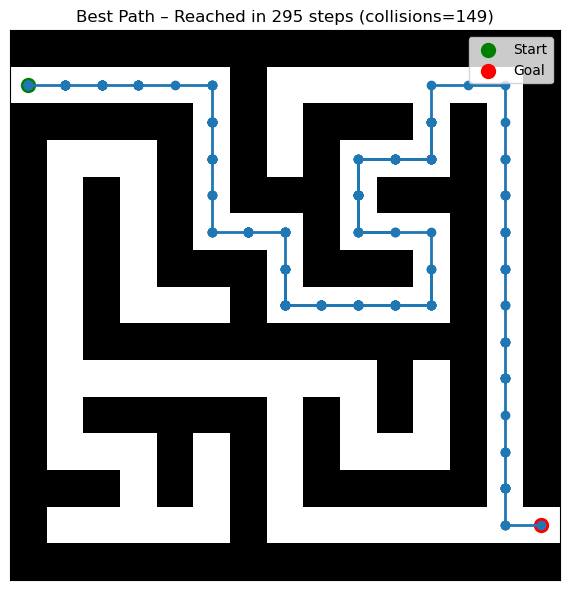

In [43]:
import random
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools

# === 1. Laberinto ===========================================================
def load_maze(filepath="maze_case_base.txt"):
    grid = []
    with open(filepath, "r") as f:
        for line in f:
            grid.append([int(x) for x in line.strip().split()])
    return np.array(grid)

MAZE = load_maze()
H, W = MAZE.shape

START = (0, 1)          # (x, y) entrada
GOAL  = (W - 1, H - 2)  # (14,13) salida
MAX_STEPS = 500

# Movimientos codificados 0-3  (↑ ↓ → ←)
MOVE_DELTAS = {0: (0, -1), 1: (0, 1), 2: (1, 0), 3: (-1, 0)}

# === 2. Configuración AG ====================================================
CHROMOSOME_LENGTH = 350
POP_SIZE   = 120
NGEN       = 400
CXPB       = 0.8
MUTPB      = 0.3
ELITE_PERC = 0.02   # 2 %

# --- DEAP -------------------------------------------------------------------
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_move", random.randint, 0, 3)   # valores 0-3
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_move, CHROMOSOME_LENGTH)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# === 3. Evaluación ==========================================================
def evaluate(individual):
    x, y = START
    collisions = 0
    path_len   = 1

    for gene in individual:
        dx, dy = MOVE_DELTAS[gene]
        nx, ny = x + dx, y + dy

        if 0 <= nx < W and 0 <= ny < H and MAZE[ny, nx] == 0:
            x, y = nx, ny
            path_len += 1
            if (x, y) == GOAL:
                break
        else:
            collisions += 1

    reached = (x, y) == GOAL
    dist    = abs(x - GOAL[0]) + abs(y - GOAL[1])

    fitness = (
        5000 if reached else -5 * dist   # gran recompensa si llega
        - 10 * collisions
        - path_len
    )
    return (fitness,)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=3, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

# === 4. Evolución ===========================================================
def run_evolution(seed=None):
    random.seed(seed)
    pop = toolbox.population(n=POP_SIZE)
    hof = tools.HallOfFame(1)

    # Evaluación inicial
    for ind in pop:
        ind.fitness.values = toolbox.evaluate(ind)

    elite_size = max(1, int(ELITE_PERC * POP_SIZE))

    for gen in range(1, NGEN + 1):
        offspring = toolbox.select(pop, len(pop) - elite_size)
        offspring = list(map(toolbox.clone, offspring))

        # Cruce
        for c1, c2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(c1, c2)
                del c1.fitness.values, c2.fitness.values

        # Mutación
        for mut in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mut)
                del mut.fitness.values

        # Re-evaluar
        for ind in offspring:
            if not ind.fitness.valid:
                ind.fitness.values = toolbox.evaluate(ind)

        pop[:] = tools.selBest(pop, elite_size) + offspring
        hof.update(pop)

        # Criterio de parada temprano
        if hof[0].fitness.values[0] > 4000:
            break

    return hof[0]

# === 5. Visualización =======================================================
def draw_path(individual, title="Best Path"):
    grid = MAZE.copy()
    x, y = START
    path_cells = [(x, y)]
    collisions = 0

    for gene in individual:
        dx, dy = MOVE_DELTAS[gene]
        nx, ny = x + dx, y + dy

        if 0 <= nx < W and 0 <= ny < H and grid[ny, nx] == 0:
            x, y = nx, ny                # avance válido
        else:
            collisions += 1              # choque; me quedo donde estoy

        path_cells.append((x, y))
        if (x, y) == GOAL:
            break

    reached = (x, y) == GOAL
    steps   = len(path_cells) - 1

    # -------- dibujar ----------
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(grid, cmap="Greys")
    xs, ys = zip(*path_cells)
    ax.plot(xs, ys, linewidth=2, marker="o")
    ax.scatter(*START, c="green", s=100, label="Start")
    ax.scatter(*GOAL,  c="red",   s=100, label="Goal")
    ax.set_title(f"{title} – {'Reached' if reached else 'Not reached'} in {steps} steps "
                 f"(collisions={collisions})")
    ax.set_xticks([]); ax.set_yticks([])
    ax.legend()
    plt.tight_layout()
    plt.show()


# === 6. Ejecución ===========================================================
if __name__ == "__main__":
    best = run_evolution(seed=42)
    print("\nMejor cromosoma:", best)
    print("Longitud:", len(best))
    print("Fitness:", best.fitness.values[0])
    draw_path(best)



Mejor cromosoma: [0, 1, 0, 1, 2, 1, 3, 0, 1, 3, 2, 2, 0, 0, 1, 2, 3, 2, 2, 1, 0, 0, 1, 3, 3, 0, 2, 2, 3, 1, 1, 3, 1, 0, 1, 0, 3, 1, 3, 2, 2, 1, 0, 2, 2, 1, 1, 2, 1, 0, 1, 1, 1, 3, 0, 2, 2, 3, 1, 0, 0, 2, 2, 3, 3, 3, 0, 1, 2, 0, 2, 3, 2, 1, 1, 0, 3, 0, 0, 1, 2, 1, 1, 2, 1, 0, 2, 0, 2, 1, 2, 1, 3, 0, 1, 1, 1, 2, 0, 0, 0, 0, 2, 1, 3, 0, 3, 2, 2, 3, 1, 3, 2, 3, 0, 0, 1, 3, 3, 3, 3, 1, 2, 1, 0, 2, 2, 3, 1, 2, 0, 2, 1, 3, 0, 2, 3, 0, 2, 0, 0, 2, 0, 2, 1, 1, 2, 2, 2, 1, 3, 3, 2, 2, 2, 0, 0, 3, 3, 1, 1, 2, 0, 0, 2, 3, 3, 2, 0, 0, 3, 1, 2, 2, 3, 3, 0, 3, 0, 1, 0, 2, 2, 3, 0, 2, 0, 1, 0, 3, 2, 0, 2, 1, 1, 1, 2, 0, 2, 1, 2, 3, 3, 1, 2, 2, 2, 3, 0, 2, 2, 3, 2, 3, 0, 3, 2, 0, 3, 2, 0, 3, 2, 1, 3, 3, 1, 3, 1, 1, 0, 0, 1, 0, 3, 2, 3, 1, 3, 1, 3, 3, 0, 1, 1, 2, 3, 3, 2, 1, 3, 2, 2, 2, 3, 1, 1, 2, 2, 1, 2, 1, 1, 3, 2, 3, 2, 2, 2, 0, 3, 3, 2, 1, 2, 0, 2, 0, 2, 3, 2, 3, 1, 1, 2, 2, 1, 0, 1, 2, 1, 1, 1, 0, 0, 3, 2, 3, 0, 1]
Longitud: 300
Fitness: 5000.0
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 

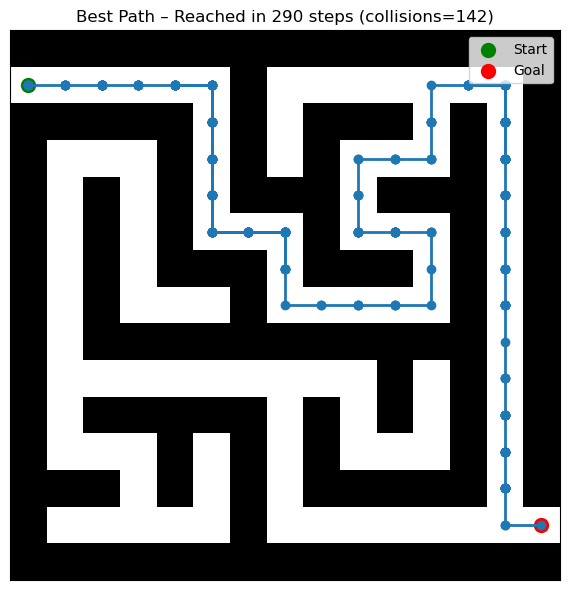

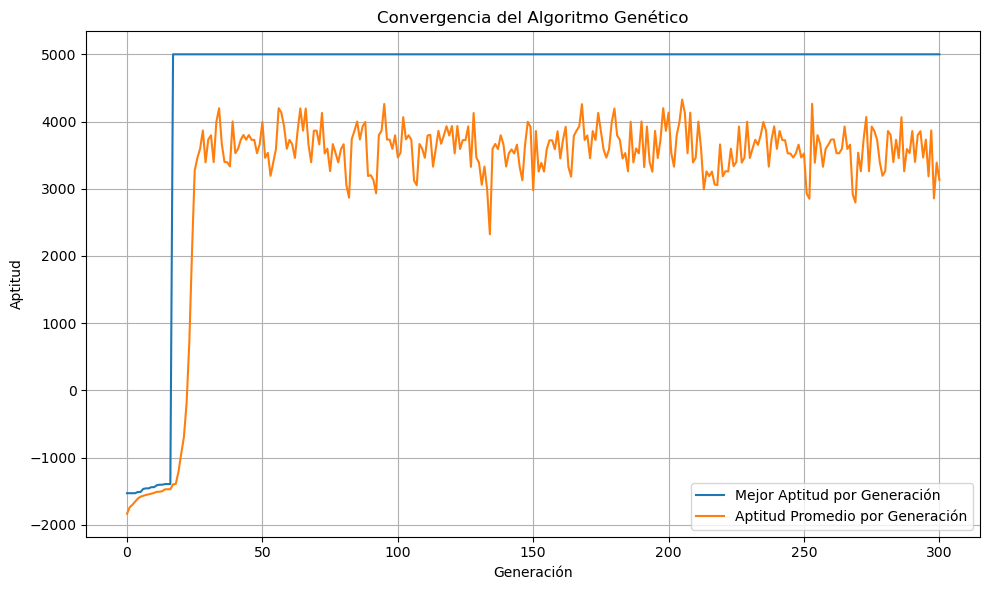

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools

# === 1. Laberinto ===========================================================
def load_maze(filepath="maze_case_base.txt"):
    grid = []
    with open(filepath, "r") as f:
        for line in f:
            grid.append([int(x) for x in line.strip().split()])
    return np.array(grid)

MAZE = load_maze()
H, W  = MAZE.shape

START = (0, 1)          # (x, y) entrada
GOAL  = (W - 1, H - 2)  # (14,13) salida
MAX_STEPS = 500

MOVE_DELTAS = {0: (0, -1), 1: (0, 1), 2: (1, 0), 3: (-1, 0)}

# === 2. Configuración AG ====================================================
CHROMOSOME_LENGTH = 300
POP_SIZE   = 100
NGEN       = 300
CXPB       = 0.6
MUTPB      = 0.2
ELITE_PERC = 0.02   # 2 %

# --- DEAP -------------------------------------------------------------------
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_move",  random.randint, 0, 3)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_move, CHROMOSOME_LENGTH)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# === 3. Evaluación ==========================================================
def evaluate(individual):
    x, y = START
    collisions = 0
    path_len   = 1

    for gene in individual:
        dx, dy = MOVE_DELTAS[gene]
        nx, ny = x + dx, y + dy

        if 0 <= nx < W and 0 <= ny < H and MAZE[ny, nx] == 0:
            x, y = nx, ny
            path_len += 1
            if (x, y) == GOAL:
                break
        else:
            collisions += 1

    reached = (x, y) == GOAL
    dist    = abs(x - GOAL[0]) + abs(y - GOAL[1])

    fitness = (
        5000 if reached else -5 * dist
        - 10 * collisions
        - path_len
    )
    return (fitness,)

toolbox.register("evaluate", evaluate)
toolbox.register("mate",    tools.cxTwoPoint)
toolbox.register("mutate",  tools.mutUniformInt, low=0, up=3, indpb=0.1)
toolbox.register("select",  tools.selTournament, tournsize=3)

# === 4. Evolución ===========================================================
def run_evolution(seed=None):
    random.seed(seed)
    pop = toolbox.population(n=POP_SIZE)
    hof = tools.HallOfFame(1)

    # ── Historias de convergencia ──────────────────────────────────────────
    best_fitness_history = []
    avg_fitness_history  = []
    gen_h = []

    # ── Evaluación inicial ────────────────────────────────────────────────
    for ind in pop:
        ind.fitness.values = toolbox.evaluate(ind)

    elite_size = max(1, int(ELITE_PERC * POP_SIZE))

    # Guarda generación 0
    fits = [ind.fitness.values[0] for ind in pop]
    best_fitness_history.append(max(fits))
    avg_fitness_history.append(sum(fits) / len(fits))
    gen_h.append(0)


    for gen in range(1, NGEN + 1):
        offspring = toolbox.select(pop, len(pop) - elite_size)
        offspring = list(map(toolbox.clone, offspring))

        # Cruce
        for c1, c2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(c1, c2)
                del c1.fitness.values, c2.fitness.values

        # Mutación
        for mut in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mut)
                del mut.fitness.values

        # Re-evaluar
        for ind in offspring:
            if not ind.fitness.valid:
                ind.fitness.values = toolbox.evaluate(ind)

        # Reemplazo + élite
        pop[:] = tools.selBest(pop, elite_size) + offspring
        hof.update(pop)

        # Guardar métricas de esta generación
        fits = [ind.fitness.values[0] for ind in pop]
        best_fitness_history.append(max(fits))
        avg_fitness_history.append(sum(fits) / len(fits))
        gen_h.append(gen)


    return hof[0], best_fitness_history, avg_fitness_history, gen_h

# === 5. Visualización =======================================================
def draw_path(individual, title="Best Path"):
    grid = MAZE.copy()
    x, y = START
    path_cells = [(x, y)]
    collisions = 0

    for gene in individual:
        dx, dy = MOVE_DELTAS[gene]
        nx, ny = x + dx, y + dy

        if 0 <= nx < W and 0 <= ny < H and grid[ny, nx] == 0:
            x, y = nx, ny
        else:
            collisions += 1

        path_cells.append((x, y))
        if (x, y) == GOAL:
            break

    reached = (x, y) == GOAL
    steps   = len(path_cells) - 1

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(grid, cmap="Greys")
    xs, ys = zip(*path_cells)
    ax.plot(xs, ys, linewidth=2, marker="o")
    ax.scatter(*START, c="green", s=100, label="Start")
    ax.scatter(*GOAL,  c="red",   s=100, label="Goal")
    ax.set_title(f"{title} – {'Reached' if reached else 'Not reached'} in {steps} steps "
                 f"(collisions={collisions})")
    ax.set_xticks([]); ax.set_yticks([])
    ax.legend()
    plt.tight_layout()
    plt.show()

def plot_convergence(best_hist, avg_hist, gen_hist):
    """Grafica la evolución de la aptitud."""
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(best_hist)), best_hist, label='Mejor Aptitud por Generación')
    plt.plot(range(len(avg_hist)), avg_hist, label='Aptitud Promedio por Generación')
    plt.xlabel('Generación')
    plt.ylabel('Aptitud')
    plt.title('Convergencia del Algoritmo Genético')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === 6. Ejecución ===========================================================
if __name__ == "__main__":
    best, best_hist, avg_hist, gen_hist = run_evolution(seed=42)

    print("\nMejor cromosoma:", best)
    print("Longitud:", len(best))
    print("Fitness:", best.fitness.values[0])

    draw_path(best)
    plot_convergence(best_hist, avg_hist, gen_hist)


### Analisis de convergencia